In [1]:
from scipy.stats import norm
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import brentq
from scipy.stats import norm

# Configuration variables
ticker = 'ATVI'


    


# Black-Scholes call and put price
def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

# Black-Scholes d1 and d2
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return [d1, d2]

# Fetch ticker and options expiration dates
comp = yf.Ticker(ticker)
exp_dates = comp.options

curr_price = comp.history(period='1d')['Close'][0]

# Latest 10 year yield for option price calculation
ten_yr = web.DataReader('DGS10', 'fred', start=datetime(2021, 1, 1))
# Senaste kursen för tickern
ten_yr = ten_yr.iloc[-1].values[0]


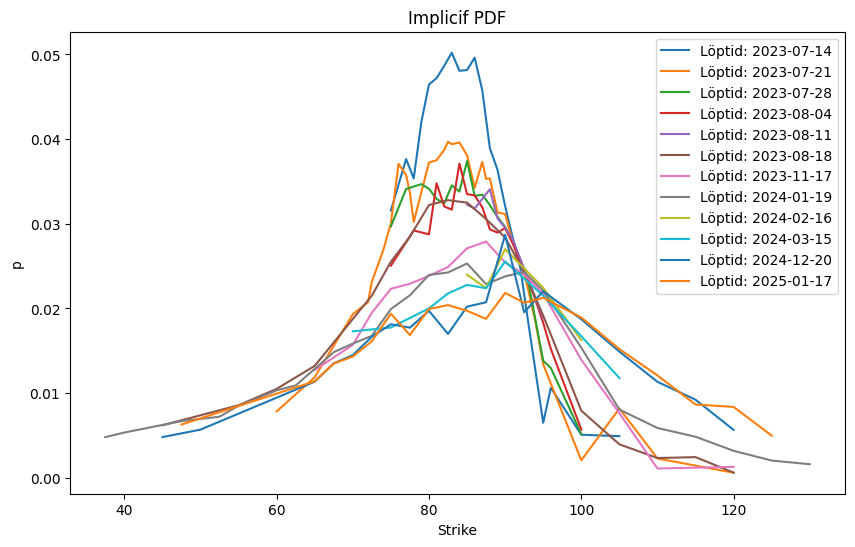

/var/folders/cz/s6vsd4w14lxb2_kkg69ybbbw0000gn/T/ipykernel_5807/1285423963.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])


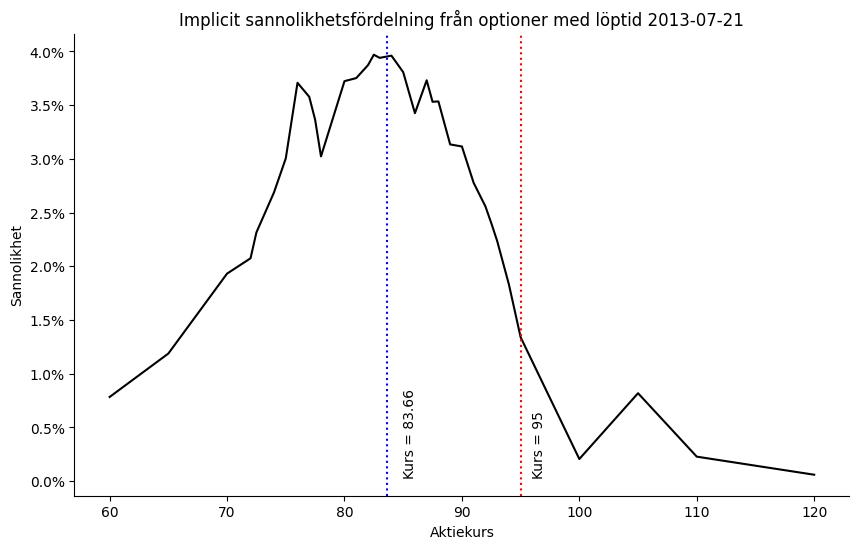

/var/folders/cz/s6vsd4w14lxb2_kkg69ybbbw0000gn/T/ipykernel_5807/1285423963.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])


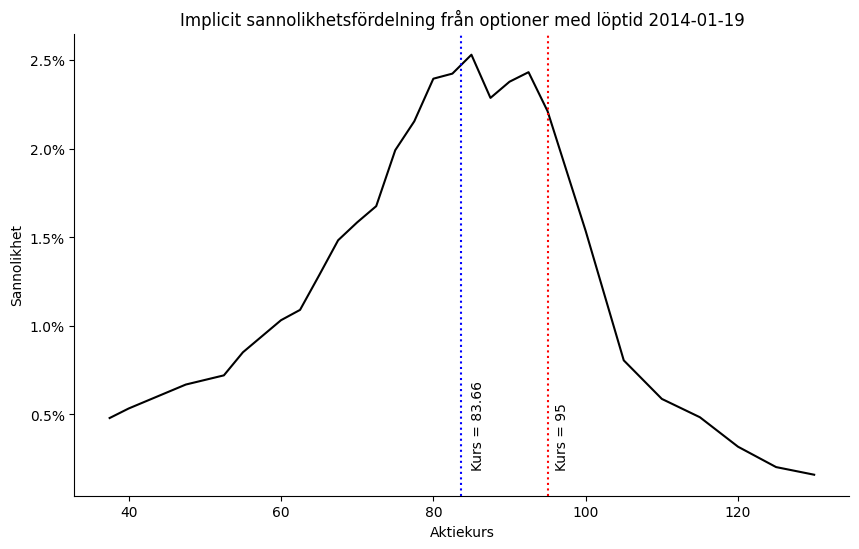

In [2]:


# Minimeringsfunktion för Brents metod
def objective(sigma, *args):
    S, K, r, t, market_price, option_type = args
    d1, d2 = d(sigma, S, K, r, t)
    if option_type == "call":
        model_price = call_price(sigma, S, K, r, t, d1, d2)
    elif option_type == "put":
        model_price = put_price(sigma, S, K, r, t, d1, d2)
    return model_price - market_price

# PDF enligt Black-Scholes
def calculate_pdf(K, r, T, sigma, S):
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    pdf = np.exp(r * T) * norm.pdf(d2) / (S * sigma * np.sqrt(T))
    return pdf

pdfs_all = []
strikes_all = []

for exp_date in exp_dates:
    options = comp.option_chain(exp_date)
    call_ivs = []
    strikes = []
    for index, row in options.calls.iterrows():
        t = (pd.to_datetime(exp_date) - datetime.now()).days / 365.0
        r = ten_yr / 100
        S = curr_price
        K = row['strike']
        market_price = row['lastPrice']
        try:
            implied_vol = brentq(objective, 0.01, 5, args=(S, K, r, t, market_price, "call"))
            call_ivs.append(implied_vol)
            strikes.append(K)  # Lägg till strike
        except ValueError:
            pass  # Hoppa över om det inte går att lösa

    # Beräkna pdf för varje strike
    pdfs = []
    for i in range(len(call_ivs)):
        pdf = calculate_pdf(strikes[i], r, t, call_ivs[i], S)
        pdfs.append(pdf)
    
    # Lagra pdf och strike för varje exp_date
    pdfs_all.append(pdfs)
    strikes_all.append(strikes)

# Plotta pdf för varje exp_date
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}')

plt.title('Implicif PDF')
plt.xlabel('Strike')
plt.ylabel('p')
plt.legend()
plt.show()

# Plotta pdf för närmaste datumet efter avtalet väntas löpa ut
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2023-07-21':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')
        # Black line
        

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2013-07-21')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')
# y axis in percentage points
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# Make a minimalistic graphic style
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add y-line at strike price 95
plt.axvline(x=95, color='r', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(96, 0.0005, 'Kurs = 95', rotation=90)
plt.axvline(x=83.66, color='b', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(85, 0.0005, 'Kurs = 83.66', rotation=90)
# No border for legend
plt.show()


# Plotta pdf för närmaste datumet efter avtalet väntas löpa ut
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2024-01-19':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')
        # Black line
        

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2014-01-19')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')
# y axis in percentage points
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# Make a minimalistic graphic style
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add y-line at strike price 95
plt.axvline(x=95, color='r', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(96, 0.002, 'Kurs = 95', rotation=90)
plt.axvline(x=83.66, color='b', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(85, 0.002, 'Kurs = 83.66', rotation=90)
# No border for legend
plt.show()



In [3]:
from scipy.integrate import quad
import numpy
import scipy

# Find the index of the expiry date
expiry_date = '2024-01-19'
index = exp_dates.index(expiry_date)

# Find the corresponding strikes and pdfs
strikes = strikes_all[index]
pdfs = pdfs_all[index]

print(strikes)
print(pdfs)

# Integrate the pdfs over all strikes
result1 = numpy.trapz(pdfs, strikes)

# Integrate the pdfs over strikes greater than 95
strikes_array = numpy.array(strikes)
pdfs_array = numpy.array(pdfs)
result2 = numpy.trapz(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95])
print(result1)
print(result2/result1)

print(scipy.integrate.simps(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95]))

[37.5, 40.0, 47.5, 52.5, 55.0, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0]
[0.0047978186073224655, 0.005336420637810772, 0.006688226132170735, 0.007206842225239398, 0.008509936938848923, 0.010321019370206443, 0.010903392500973387, 0.012851619839911507, 0.014835299770382851, 0.015844729465698516, 0.016760075940707404, 0.019921059205358145, 0.021551661795767292, 0.02395618109388429, 0.024242480848805, 0.025309825056926527, 0.022871397109318525, 0.023785370239400538, 0.024324115866980186, 0.022120196232055474, 0.015359090593752197, 0.008053820702614192, 0.005877295271239231, 0.0048412478043895445, 0.003178875803759446, 0.002028219807652681, 0.0015970210890010991]
1.098651594622912
0.2329999742161566
0.2533483320031564
